In [316]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

In [317]:
path_train_data = r"./data/sales_train_v2.csv"
path_test_data = r"./data/test.csv"
path_sample_submission = r'./data/sample_submission.csv'
path_items = r"./info/items.csv"
path_shops = r"./info/shops.csv"
path_item_categories = r"./info/item_categories.csv"

In [318]:
schema_train = {
    "date":str,
    "date_block_num": 'category',
    "shop_id": 'category',
    "item_id": 'category',
    "item_price": float,
    "item_cnt_day": float
}

schema_test = {
    "ID": str,
    "shop_id": 'category',
    "item_id": 'category',
    "item_cnt_day": float
}

schema_test = {
    "ID": str,
    "item_cnt_moth": float
}

schema_items = {
    "item_name": str,
    "item_id": str,
    "item_category_id": 'category'
}

schema_shops = {
    "shop_name": str,
    "shop_id": str
}

schema_item_categories = {
    "item_category_name": str,
    "item_category_id": str
}

In [324]:
df_raw = pd.read_csv(path_train_data, dtype=schema_train)
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%d.%m.%Y')

df_test = pd.read_csv(path_test_data, dtype=schema_test)
df_items = pd.read_csv(path_items, dtype=schema_items)
df_shops = pd.read_csv(path_shops, dtype=schema_shops)
df_item_cat = pd.read_csv(path_item_categories, dtype=schema_item_categories)


In [325]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [326]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [327]:
df_item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null object
shop_id    214200 non-null category
item_id    214200 non-null category
dtypes: category(2), object(1)
memory usage: 2.4+ MB


In [29]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    category
shop_id           category
item_id           category
item_price        float64
item_cnt_day      float64
dtypes: category(3), datetime64[ns](1), float64(2)
memory usage: 79.2 MB


## Copy train set

In [18]:
df_train = df_raw.copy()

In [92]:
# Drop duplicates
df_train.drop_duplicates(inplace=True)

In [ ]:
# Build a hash key for each row - takes some time to run
df_train['hashkey'] = df_train.apply(lambda x: hash(tuple(x)), axis = 1)

In [89]:
df_train['hashkey'] = df_train['hashkey'].astype(str)

In [97]:
# Set the hsh key as index
df_train.set_index('hashkey', inplace=True)

## Explore data

In [98]:
df_train.describe(include='all')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935843,2935843,2935843,2935843,2.935843e+06,2.935843e+06
unique,1034,34,60,21807,NaN,NaN
top,2013-12-28 00:00:00,11,31,20949,NaN,NaN
freq,9434,143246,235636,31340,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,8.908535e+02,1.242641e+00
std,NaN,NaN,NaN,NaN,1.729801e+03,2.618837e+00
min,NaN,NaN,NaN,NaN,-1.000000e+00,-2.200000e+01
25%,NaN,NaN,NaN,NaN,2.490000e+02,1.000000e+00


*item_cnt_day* can be negative due to refund/return.

### But why does *item_price* be -1?

In [99]:
df_train['item_price'].value_counts().sort_index()

-1.000000            1
 0.070000            2
 0.087500            1
 0.090000            1
 0.100000         2932
 0.200000            1
 0.500000         1226
 0.908714            1
 0.990000          493
 1.000000            1
 1.830000           11
 2.000000           11
 2.990000            1
 3.000000         1234
 3.570000            3
 3.590000            2
 3.640000            2
 3.670000            1
 3.690000            2
 3.710000            3
 3.720000            6
 3.800000            2
 4.000000          105
 4.029126            1
 4.055556            1
 4.142857            1
 4.235294            1
 4.300000            1
 4.333333            1
 4.400000            1
                  ... 
 31599.000000        1
 31699.000000        1
 31990.000000       19
 32092.000000        1
 32199.000000       16
 32382.000000        1
 32437.000000        1
 32490.000000        4
 32990.000000       57
 32997.500000        1
 33490.000000        8
 33990.000000        1
 34490.0000

There is only 1 existence of (-1), so it may be an error/NaN/missing value, or can be a refund.

Let's check where it happens to decide what to do.

In [100]:
df_train[df_train['item_price']==-1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
hashkey,,,,,,
-4728922553389137420,2013-05-15,4,32,2973,-1.0,1.0


It happens on May 15 2013, shop 32, on item 2973, and sold 1 item. Let's plot the trend of item price of that item in that shop.

In [101]:
df_train_tmp1 = df_train[(df_train.shop_id == '32') & (df_train.item_id == '2973')].sort_values('date')

In [102]:
df_train_tmp1

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
hashkey,,,,,,
-5915001693748161002,2013-01-15,0,32,2973,2499.0,3.0
-8418698904327507740,2013-01-17,0,32,2973,2499.0,1.0
-1146380207405833760,2013-01-18,0,32,2973,2499.0,1.0
-4219922122459772304,2013-01-21,0,32,2973,2499.0,1.0
1557883210670965873,2013-01-22,0,32,2973,2499.0,1.0
-5403088348248029637,2013-01-25,0,32,2973,2499.0,1.0
20803600598159012,2013-01-29,0,32,2973,2499.0,1.0
6719369485333451006,2013-02-05,1,32,2973,2499.0,1.0
2082638383150524814,2013-02-14,1,32,2973,2499.0,1.0


Looks like an error of some sort. The price changed quite a bit between May 6 (\$2499) and May 23 (\$1249.5), thus I cannot be sure what the exact price on May 15 was... I would just remove this entry for simplicity.

Note that when there is no transaction for an item, there is no record. So the exact item price is unknown.

In [103]:
df_train.drop('-4728922553389137420', inplace=True)

In [105]:
df_train[(df_train.shop_id == '32') & (df_train.item_id == '2973')].sort_values('date')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
hashkey,,,,,,
-5915001693748161002,2013-01-15,0,32,2973,2499.0,3.0
-8418698904327507740,2013-01-17,0,32,2973,2499.0,1.0
-1146380207405833760,2013-01-18,0,32,2973,2499.0,1.0
-4219922122459772304,2013-01-21,0,32,2973,2499.0,1.0
1557883210670965873,2013-01-22,0,32,2973,2499.0,1.0
-5403088348248029637,2013-01-25,0,32,2973,2499.0,1.0
20803600598159012,2013-01-29,0,32,2973,2499.0,1.0
6719369485333451006,2013-02-05,1,32,2973,2499.0,1.0
2082638383150524814,2013-02-14,1,32,2973,2499.0,1.0


### Let's forget about shops and items, plot the overall sales and see how it fluctuates.

This helps explore overall market trend, seasonal trend, tactical sales, and any abnormality.

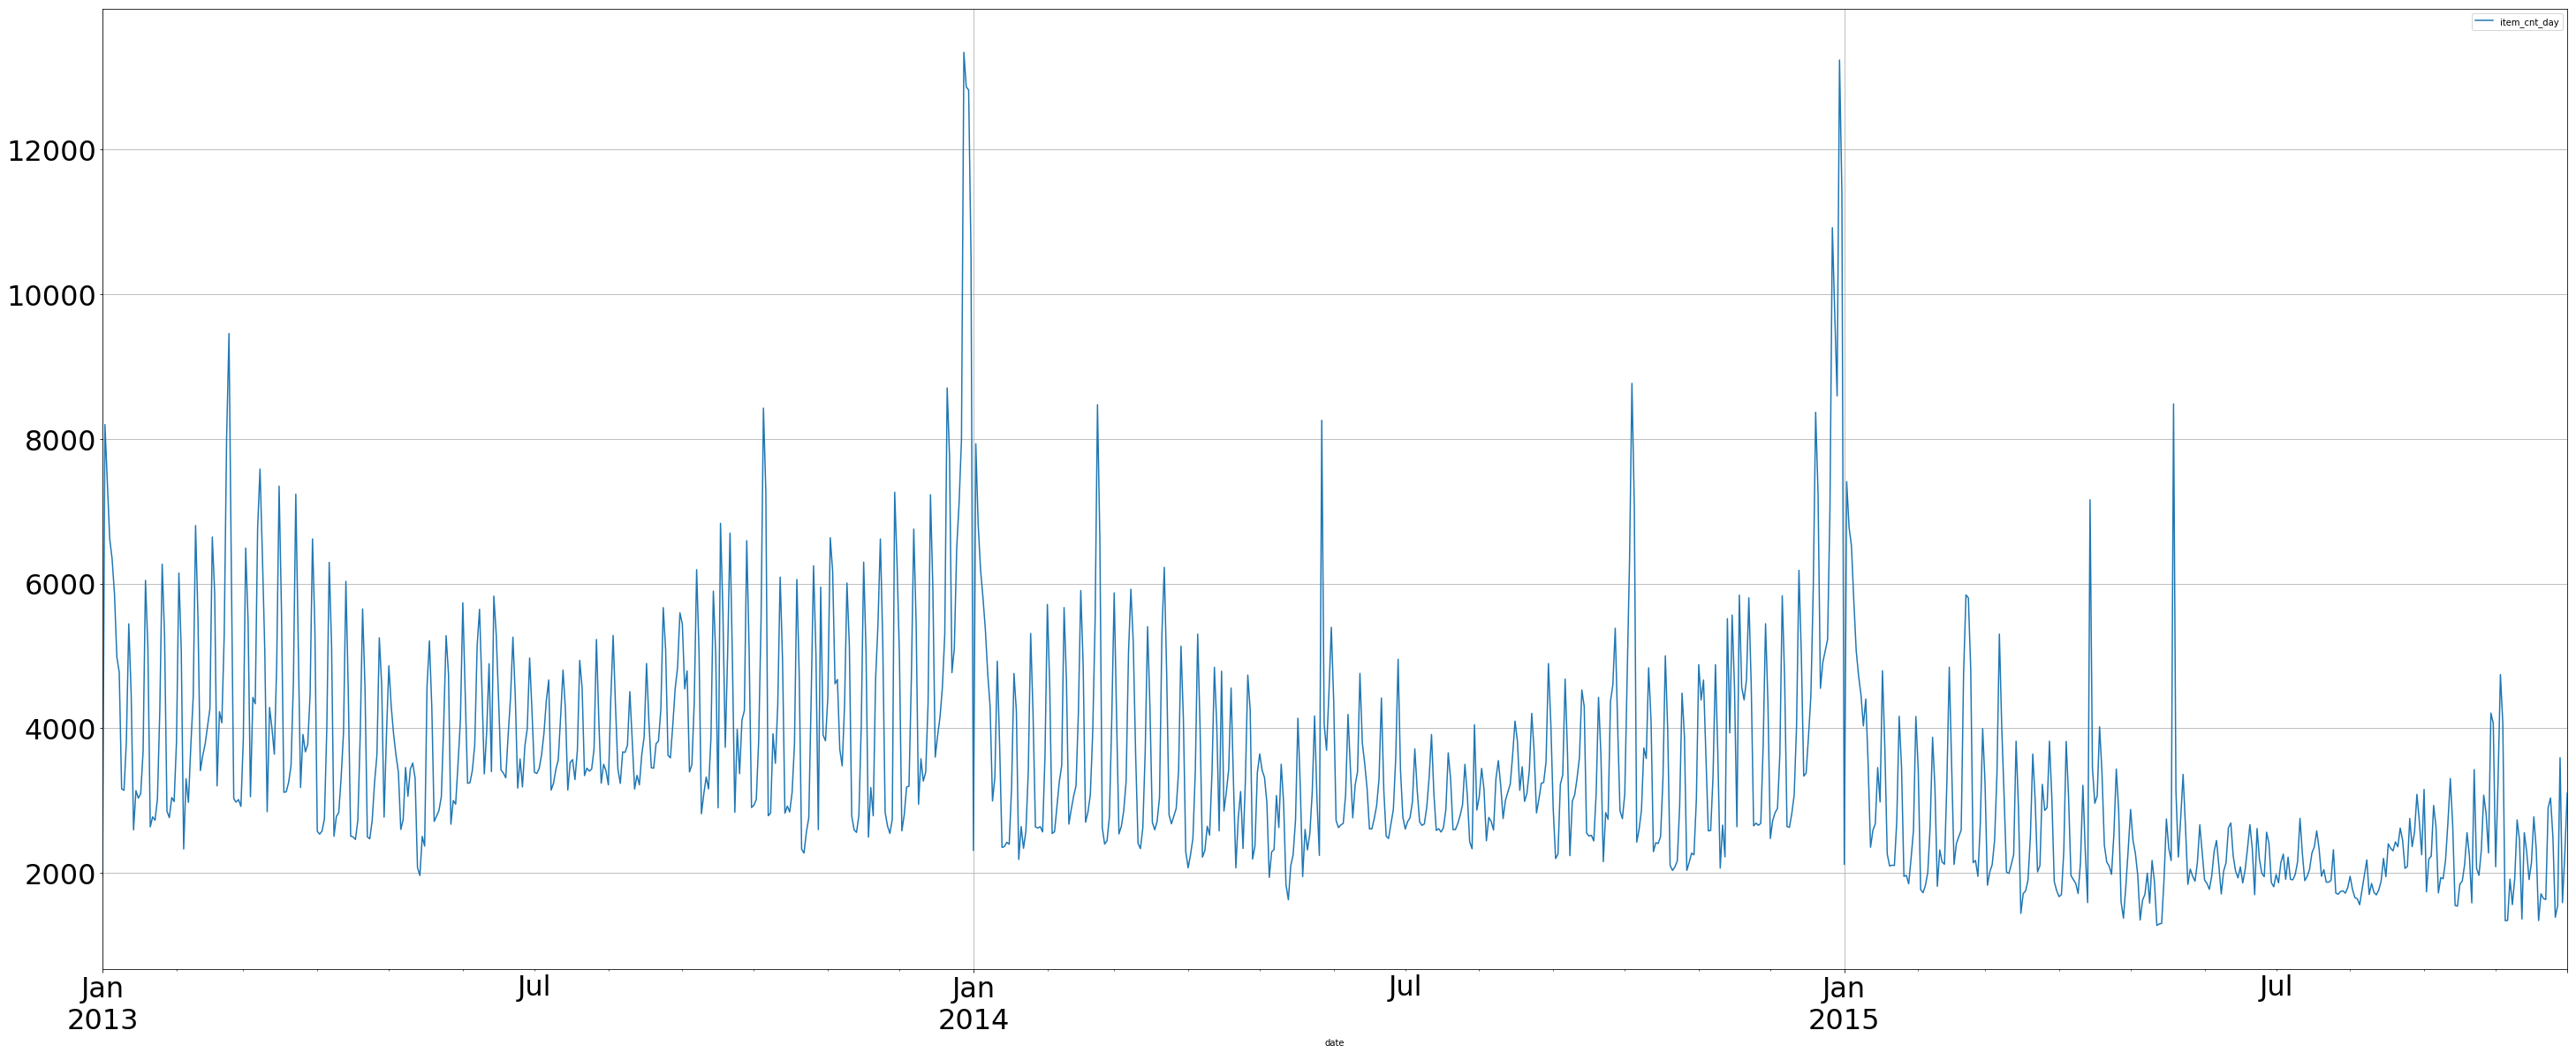

In [129]:
df_train_agg_1 = df_train.groupby('date').agg({'item_cnt_day':sum})
df_train_agg_1.plot(figsize=(50,20), fontsize=32, grid=True)

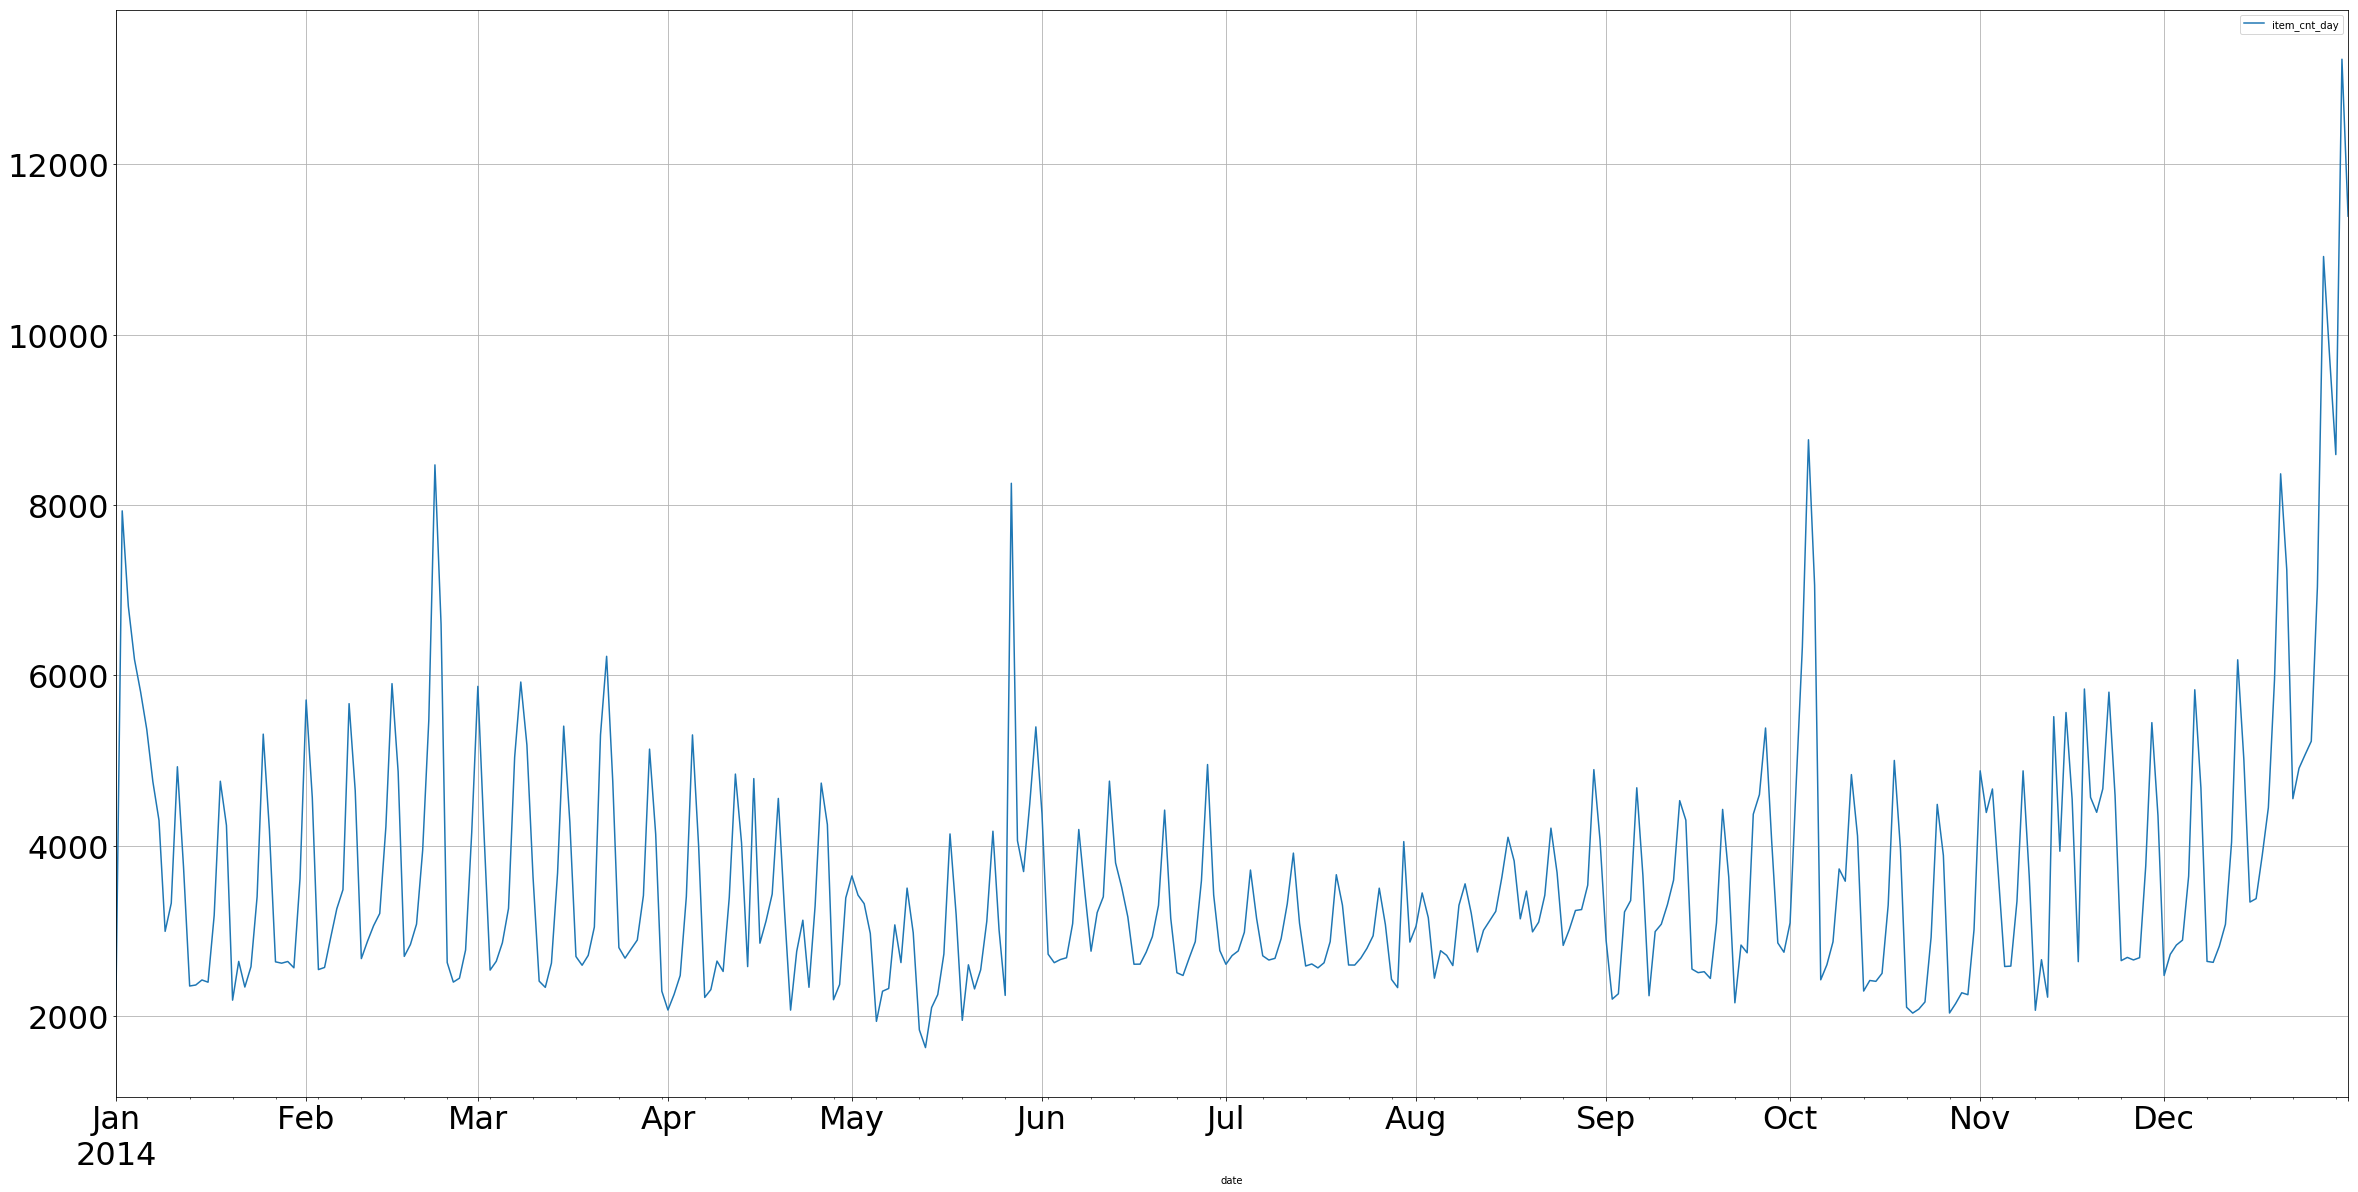

In [128]:
df_train_agg_2 = df_train[(df_train['date']>=datetime(2014,1,1)) & (df_train['date']<=datetime(2014,12,31))].groupby('date').agg({'item_cnt_day':sum})
df_train_agg_2.plot(figsize=(40,20), fontsize=32, grid=True)

We can see a few things from this plot:
1. overall, there is a declining trend in total item sold. (but we are not sure about total revenue)
2. there is a clear weekly trend in item sale, which suggest weekday can be a good feature.

### Let's plot the total revenue by date, then average item price by date.

In [131]:
# Revenue by date
df_train['item_rev'] = df_train['item_price'] * df_train['item_cnt_day']
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_rev
hashkey,,,,,,,
6219403433820114488,2013-01-02,0,59,22154,999.00,1.0,999.00
5795926769905178163,2013-01-03,0,25,2552,899.00,1.0,899.00
5513180054245085460,2013-01-05,0,25,2552,899.00,-1.0,-899.00
-457359498714245617,2013-01-06,0,25,2554,1709.05,1.0,1709.05
-5469836883299482262,2013-01-15,0,25,2555,1099.00,1.0,1099.00


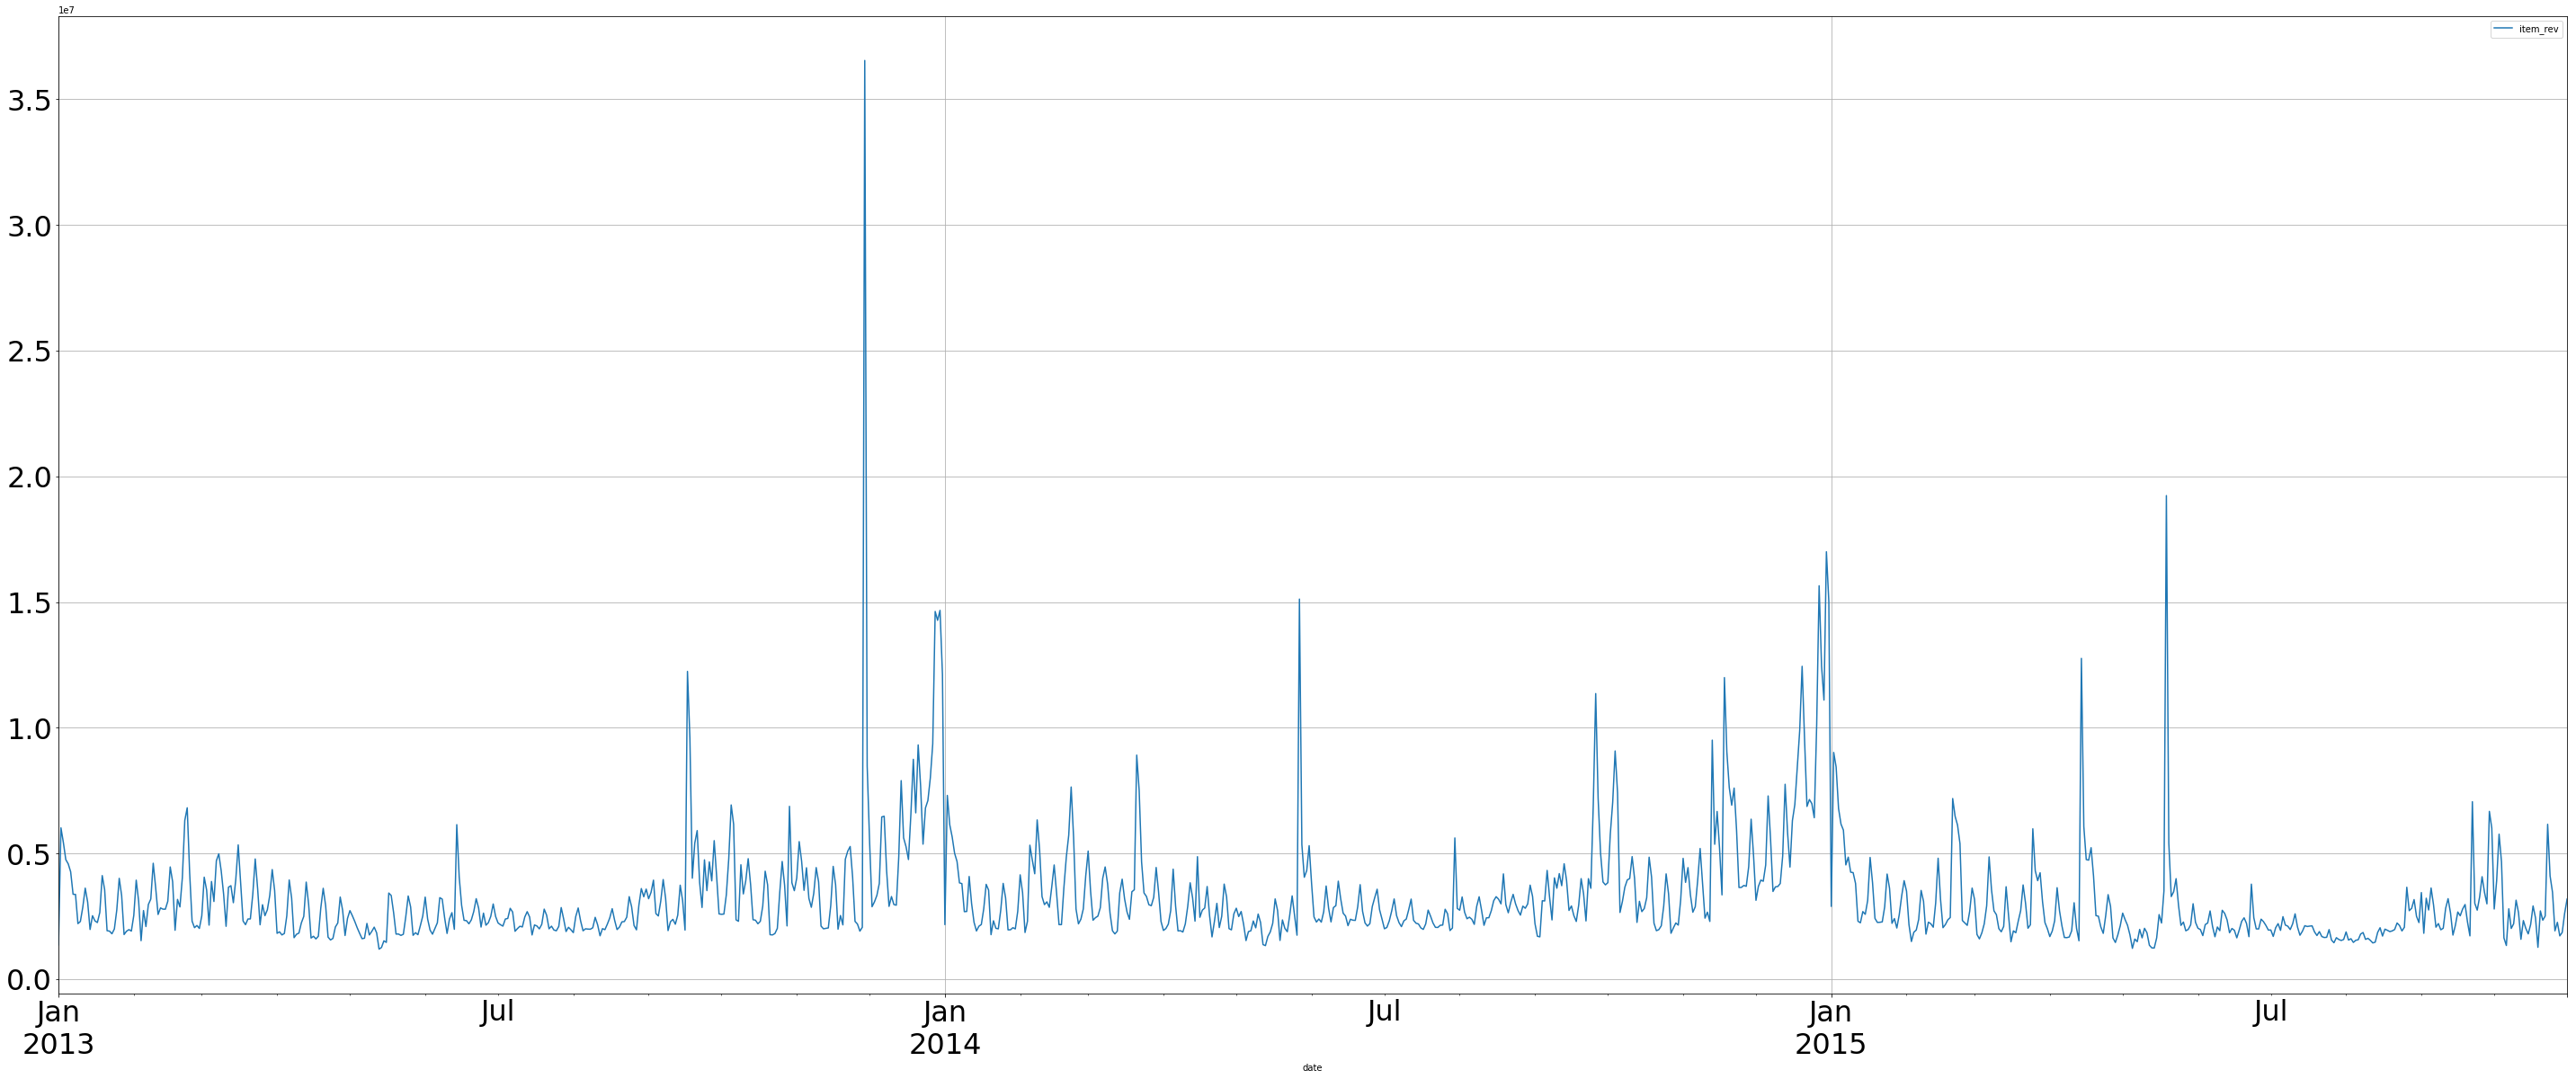

In [132]:
df_train_rev_agg_1 = df_train.groupby('date').agg({'item_rev':sum})
df_train_rev_agg_1.plot(figsize=(50,20), fontsize=32, grid=True)

There is an interesting spike around 2013 year end. What was it?

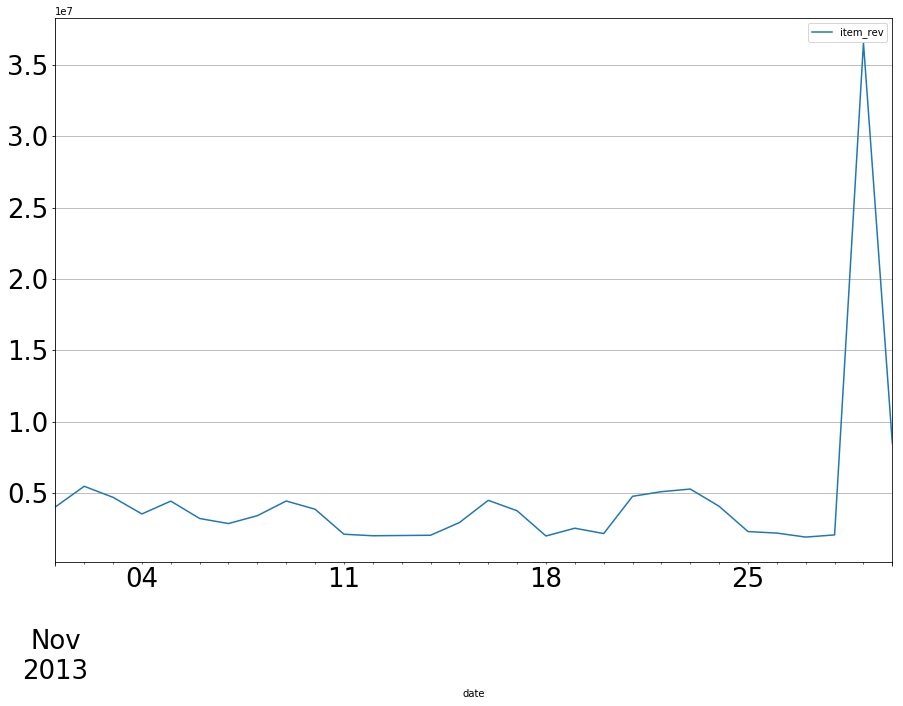

In [139]:
df_train_rev_agg_2 = df_train[(df_train['date']>=datetime(2013,11,1)) & (df_train['date']<=datetime(2013,11,30))].groupby('date').agg({'item_rev':sum})
df_train_rev_agg_2.plot(figsize=(15,10), fontsize=26, grid=True)

So it was late Nov 2013... was it a tactical sale, or product launch? Let's figure out by looking at the item prices of top-selling (in terms of revenue) items.

That is, we select the top (say 5) items with most revenue, and plot their prices across time.

In [270]:
# get the date with most rev
df_train[(df_train['date']>=datetime(2013,11,25)) & (df_train['date']<=datetime(2013,12,2))].groupby('date').agg({'item_rev':sum}).sort_values('item_rev', ascending=False)

,item_rev
date,
2013-11-29,3.654481e+07
2013-11-30,8.475981e+06
2013-12-01,5.455816e+06
2013-12-02,2.881501e+06
2013-11-25,2.298599e+06
2013-11-26,2.191083e+06
2013-11-28,2.064043e+06
2013-11-27,1.910781e+06


Something happened between Nov 29 and Dec 1.

In [274]:
# get the top 5 items
df_grp_items = \
df_train[(df_train['date']==datetime(2013,11,29)) & (df_train['date']<=datetime(2013,12,1))]\
.groupby('item_id')\
.agg({'item_rev':sum})

In [278]:
top_10_rev = df_grp_items['item_rev'].nlargest(5).index.tolist()
top_10_rev

['6675', '4231', '3333', '5672', '5671']

In [281]:
df_flt_topitems = df_train[df_train.item_id.isin(top_10_rev)]
df_flt_topitems.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_rev
hashkey,,,,,,,
6621969247837129692,2013-11-29,10,28,6675,18380.243902,41.0,753589.999998
-1192318283597071659,2013-11-30,10,28,6675,18240.000000,4.0,72960.000000
-396662264000233980,2013-11-29,10,28,5671,2590.000000,14.0,36260.000000
-1505534513443619972,2013-11-30,10,28,5671,2590.000000,3.0,7770.000000
3076967988466614705,2013-11-29,10,28,5672,2590.000000,4.0,10360.000000


In [282]:
# Plotting
df_topitems = df_flt_topitems.groupby(['date','item_id']).agg({'item_price':np.mean}).reset_index()
df_topitems['date_str'] = df_topitems['date'].apply(lambda x: datetime.strftime(x, '%Y%m%d'))

In [290]:
df_topitems.head()

,date,item_id,item_price,date_str
0,2013-11-22,4231,2758.985714,20131122
1,2013-11-23,4231,2799.000000,20131123
2,2013-11-24,4231,2799.000000,20131124
3,2013-11-25,4231,2799.000000,20131125
4,2013-11-26,4231,2769.470588,20131126


In [292]:
pvt_topitems = df_topitems[(df_topitems['date']>=datetime(2013,11,27)) & (df_topitems['date']<=datetime(2013,12,1))].pivot(index='date', columns='item_id', values='item_price')

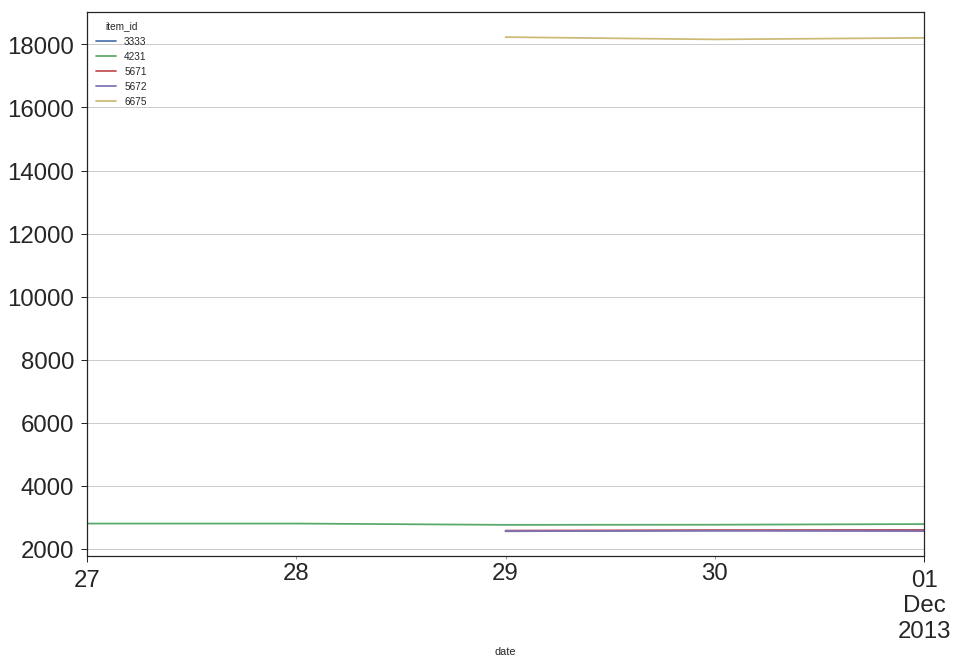

In [297]:
pvt_topitems.plot(figsize=(15,10), fontsize=24, grid=True)

Item 6675 and 5672 went on sale staring from Nov 29. Checking items.csv, they are PS4 and its accessory. No wonder.

That gives us an idea: when there is a new, popular product goes on sale, it is likely to skew the sales (in revenue and item count) up. There may be a cannibal effect on existing products too.

Let's check the test.csv file of prediction perod, 2015 Nov, and compare the item list against 2015 Oct.

In [298]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [301]:
# Get the list of item to predict on Nov 2015
set_item_2015Nov = set(df_test.item_id.tolist())
len(set_item_2015Nov)

5100

In [304]:
# Get the list of item on sale on Oct 2015
set_item_2015Oct = set(df_train[(df_train['date']>=datetime(2015,10,1)) & (df_train['date']<=datetime(2015,10,31))].item_id.tolist())
len(set_item_2015Oct)

5413

So there are more items on sale on Oct than we are to predict in Nov. Are all items to be predicted already exist in Oct? Let's find out.

In [307]:
len(set_item_2015Oct - set_item_2015Nov)

1422

In [308]:
len(set_item_2015Nov - set_item_2015Oct)

1109

We are getting huge difference here - what was wrong?

Remember what we found previously - if there was no purchase of an item, then there would be no record. Let's check again all previously on-the-shelf items before 2015 Nov.

In [310]:
set_item_all = set(df_train.item_id.tolist())
len(set_item_all)

21807

In [314]:
set_item_2015Nov - set_item_all

{'10028',
 '10045',
 '10054',
 '10069',
 '10176',
 '10203',
 '10310',
 '10372',
 '10483',
 '10507',
 '10747',
 '10779',
 '11267',
 '11385',
 '11762',
 '11764',
 '11765',
 '1184',
 '1193',
 '11946',
 '11974',
 '12117',
 '12409',
 '12441',
 '1246',
 '12468',
 '12469',
 '12470',
 '12471',
 '1252',
 '1253',
 '1254',
 '12568',
 '12574',
 '12591',
 '12802',
 '1284',
 '12890',
 '12920',
 '12961',
 '13047',
 '13096',
 '13209',
 '13231',
 '13232',
 '13242',
 '13249',
 '13250',
 '13251',
 '13257',
 '13263',
 '13264',
 '13271',
 '13273',
 '13275',
 '13284',
 '13295',
 '13303',
 '13309',
 '13310',
 '13313',
 '13338',
 '13392',
 '13394',
 '13402',
 '13445',
 '13446',
 '13447',
 '13558',
 '13559',
 '13745',
 '13804',
 '13805',
 '13846',
 '1386',
 '1394',
 '140',
 '1434',
 '1436',
 '1437',
 '14383',
 '14521',
 '14647',
 '14648',
 '14662',
 '14739',
 '14760',
 '14765',
 '14784',
 '14832',
 '14959',
 '14972',
 '15033',
 '15034',
 '15183',
 '15329',
 '15330',
 '15418',
 '15467',
 '15553',
 '15564',
 '15

In [313]:
len(set_item_2015Nov - set_item_all)

363

There are 363 new items on 2015 Nov! We will need to find out more about them to make a prediction. But let's save them for now, and focus on existing products.

# Baseline prediction 1 - use last month's sale

One of the simplest prediction is to use last month's sale record directly. Since we are to predict 2015 Nov sale, let's aggregate 2015 Oct data. 

In [332]:
# Create month and year features to make our life easier.
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_rev,year,month
hashkey,,,,,,,,,
6219403433820114488,2013-01-02,0,59,22154,999.00,1.0,999.00,2013,1
5795926769905178163,2013-01-03,0,25,2552,899.00,1.0,899.00,2013,1
5513180054245085460,2013-01-05,0,25,2552,899.00,-1.0,-899.00,2013,1
-457359498714245617,2013-01-06,0,25,2554,1709.05,1.0,1709.05,2013,1
-5469836883299482262,2013-01-15,0,25,2555,1099.00,1.0,1099.00,2013,1


In [359]:
# slice data in 2015 Oct
df_oct15 = df_train.query('(year == 2015) & (month == 10)')
df_oct15.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_rev,year,month
hashkey,,,,,,,,,
-1018282060499582240,2015-10-23,33,45,13315,649.0,1.0,649.0,2015,10
-3316193897018337587,2015-10-05,33,45,13880,229.0,1.0,229.0,2015,10
-842244852326733295,2015-10-02,33,45,13881,659.0,1.0,659.0,2015,10
6985087438407581527,2015-10-12,33,45,13881,659.0,1.0,659.0,2015,10
7878641946406207178,2015-10-04,33,45,13923,169.0,1.0,169.0,2015,10


In [360]:
# we only need some of the columns, so keep only the ones we do need
df_oct15 = df_oct15[['shop_id', 'item_id', 'item_cnt_day']]
df_oct15.head()

,shop_id,item_id,item_cnt_day
hashkey,,,
-1018282060499582240,45,13315,1.0
-3316193897018337587,45,13880,1.0
-842244852326733295,45,13881,1.0
6985087438407581527,45,13881,1.0
7878641946406207178,45,13923,1.0


In [361]:
# Aggregate daily sales to month
df_oct15 = df_oct15.groupby(['shop_id', 'item_id']).agg({'item_cnt_day':sum}).reset_index()
df_oct15.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace=True)
df_oct15.head()

,shop_id,item_id,item_cnt_month
0,10,10042,1.0
1,10,10132,1.0
2,10,10200,3.0
3,10,10201,17.0
4,10,10202,11.0


In [362]:
# Join with test data
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [363]:
df_test_baseline1 = df_test.merge(df_oct15, how='left', on=['shop_id', 'item_id'])
df_test_baseline1.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,NaN
1,1,5,5320,NaN
2,2,5,5233,1.0
3,3,5,5232,NaN
4,4,5,5268,NaN


In [364]:
# Fill NaN with 0s
df_test_baseline1.fillna(0, inplace=True)
df_test_baseline1.tail()

,ID,shop_id,item_id,item_cnt_month
214195,214195,45,18454,1.0
214196,214196,45,16188,0.0
214197,214197,45,15757,0.0
214198,214198,45,19648,0.0
214199,214199,45,969,0.0


In [366]:
df_test_baseline1['item_cnt_month'].describe()

count    214200.000000
mean          0.293413
std           5.550976
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2253.000000
Name: item_cnt_month, dtype: float64

In [367]:
# Clip to [0, 20]
def clip_cnt(number):
    if number<0:
        return 0
    elif number > 20:
        return 20
    else:
        return number

In [370]:
df_test_baseline1['item_cnt_month'] = df_test_baseline1['item_cnt_month'].apply(clip_cnt)

In [371]:
df_test_baseline1['item_cnt_month'].describe()

count    214200.000000
mean          0.255649
std           1.089856
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month, dtype: float64

In [372]:
df_test_baseline1.head()

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


In [374]:
# Prepare submission file
df_test_baseline1 = df_test_baseline1[['ID', 'item_cnt_month']]
df_test_baseline1.head()

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [375]:
# Write to csv
df_test_baseline1.to_csv('./prediction/baseline1.csv', encoding='utf-8', index=False)